Задание: провести обработку данных и построить предсказательную модель с использованием функционала pySpark.

In [54]:
# Ksenia
# 03/03/24
# v.01

In [91]:
import pyspark
import random
from pyspark.sql import SparkSession
import pyspark.sql
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [56]:
spark=SparkSession.builder.appName('data_wine').getOrCreate()

In [77]:
# загрузка данных из CSV
df = spark.read.csv("winequality-red.csv", sep=',',  header=True, inferSchema=True)

In [78]:
df.show()

+-------------+----------------+-----------+--------------+-------------------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|          chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+-------------------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|              0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|              0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|              0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|
|         11.2|            0.28|       0

In [79]:
df.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



In [109]:
# Описание статистик данных
df.summary().show()

+-------+------------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+------------------+------------+
|summary|     fixed acidity|   volatile acidity|        citric acid|    residual sugar|           chlorides|free sulfur dioxide|total sulfur dioxide|             density|                 pH|         sulphates|           alcohol|           quality|   wine_type|
+-------+------------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+------------------+------------+
|  count|              1599|               1599|               1599|              1599|                1599|               1599|                1599|                1599|               1599|              1599|        

In [110]:
from pyspark.sql.functions import col, sum

# Подсчет количества пропущенных значений в каждом столбце
missing_values = df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns))

# Показать количество пропущенных значений в каждом столбце
missing_values.show()


+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+---------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density| pH|sulphates|alcohol|quality|wine_type|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+---------+
|            0|               0|          0|             0|        0|                  0|                   0|      0|  0|        0|      0|      0|        0|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+---------+



In [111]:
from pyspark.sql import functions as F

#группировка по качеству вина
from pyspark.sql.functions import avg, round

group_quality= df.groupBy('quality').agg(
    round(avg('fixed acidity'), 2).alias('avg_fixed_acidity'),
    round(avg('volatile acidity'), 2).alias('avg_volatile_acidity'),
    round(avg('citric acid'), 2).alias('avg_citric_acid'),
    round(avg('residual sugar'), 2).alias('avg_residual_sugar'),
    round(avg('chlorides'), 2).alias('avg_chlorides'),
    round(avg('free sulfur dioxide'), 2).alias('avg_free_sulfur_dioxide'),
    round(avg('total sulfur dioxide'), 2).alias('avg_total_sulfur_dioxide'),
    round(avg('density'), 2).alias('avg_density'),
    round(avg('pH'), 2).alias('avg_pH'),
    round(avg('sulphates'), 2).alias('avg_sulphates'),
    round(avg('alcohol'), 2).alias('avg_alcohol')
).orderBy('quality')

group_quality.show()


+-------+-----------------+--------------------+---------------+------------------+-------------+-----------------------+------------------------+-----------+------+-------------+-----------+
|quality|avg_fixed_acidity|avg_volatile_acidity|avg_citric_acid|avg_residual_sugar|avg_chlorides|avg_free_sulfur_dioxide|avg_total_sulfur_dioxide|avg_density|avg_pH|avg_sulphates|avg_alcohol|
+-------+-----------------+--------------------+---------------+------------------+-------------+-----------------------+------------------------+-----------+------+-------------+-----------+
|      3|             8.36|                0.88|           0.17|              2.64|         0.12|                   11.0|                    24.9|        1.0|   3.4|         0.57|       9.96|
|      4|             7.78|                0.69|           0.17|              2.69|         0.09|                  12.26|                   36.25|        1.0|  3.38|          0.6|      10.27|
|      5|             8.17|             

In [112]:
# подсчет количества записей в каждой категории quality:
group_q_count = df.groupBy('quality').count().orderBy('quality')
group_q_count.show()


+-------+-----+
|quality|count|
+-------+-----+
|      3|   10|
|      4|   53|
|      5|  681|
|      6|  638|
|      7|  199|
|      8|   18|
+-------+-----+



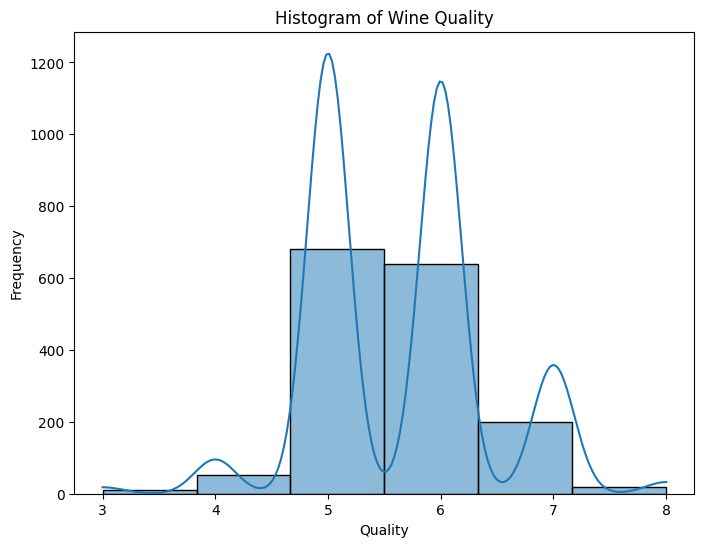

In [113]:
# гистограмма для качества вина

# Преобразование столбца PySpark DataFrame в объект Pandas Series
quality_series = df.select('quality').toPandas()['quality']

plt.figure(figsize=(8, 6))
sns.histplot(quality_series, bins=6, kde=True)
plt.title('Histogram of Wine Quality')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.show()

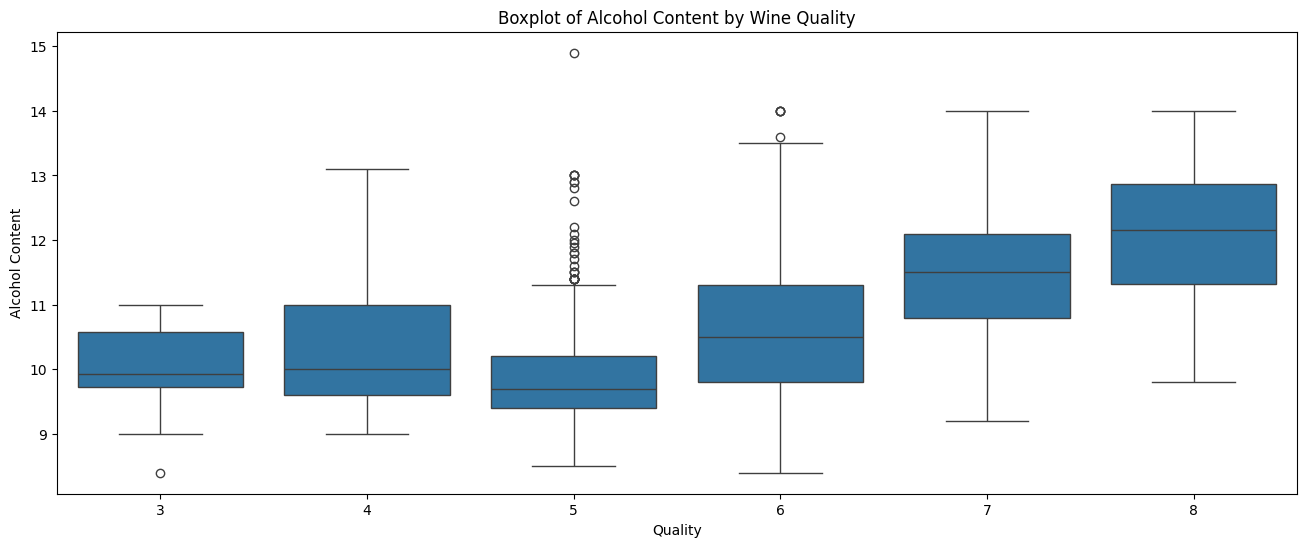

In [96]:
# Визуализация зависимости качества вина от других признаков

quality_series = df.select('quality').toPandas()['quality']
alco_series = df.select('alcohol').toPandas()['alcohol']
plt.figure(figsize=(16, 6))
sns.boxplot(x=quality_series, y=alco_series)
plt.title('Boxplot of Alcohol Content by Wine Quality')
plt.xlabel('Quality')
plt.ylabel('Alcohol Content')
plt.show()

In [65]:
#группировка по кислотности вина и вывод количества в каждой группе
acid_group = df.groupBy('pH').count().orderBy('pH')
acid_group.show()


+----+-----+
|  pH|count|
+----+-----+
|2.74|    1|
|2.86|    1|
|2.87|    1|
|2.88|    2|
|2.89|    4|
| 2.9|    1|
|2.92|    4|
|2.93|    3|
|2.94|    4|
|2.95|    1|
|2.98|    5|
|2.99|    2|
| 3.0|    6|
|3.01|    5|
|3.02|    8|
|3.03|    6|
|3.04|   10|
|3.05|    8|
|3.06|   10|
|3.07|   11|
+----+-----+
only showing top 20 rows



In [66]:
# группировка по содержанию сахара и спирта
sug_group = df.groupBy('residual sugar').agg(
    round(avg('alcohol'), 2).alias('avg_alcohol')
).orderBy('residual sugar')

sug_group.show()

+--------------+-----------+
|residual sugar|avg_alcohol|
+--------------+-----------+
|           0.9|       12.7|
|           1.2|      11.33|
|           1.3|       10.4|
|           1.4|      10.24|
|           1.5|      10.06|
|           1.6|      10.11|
|          1.65|      12.15|
|           1.7|      10.31|
|          1.75|      11.75|
|           1.8|      10.35|
|           1.9|      10.06|
|           2.0|      10.22|
|          2.05|       11.7|
|           2.1|      10.53|
|          2.15|       11.9|
|           2.2|      10.42|
|          2.25|        9.8|
|           2.3|      10.45|
|          2.35|        9.4|
|           2.4|      10.81|
+--------------+-----------+
only showing top 20 rows



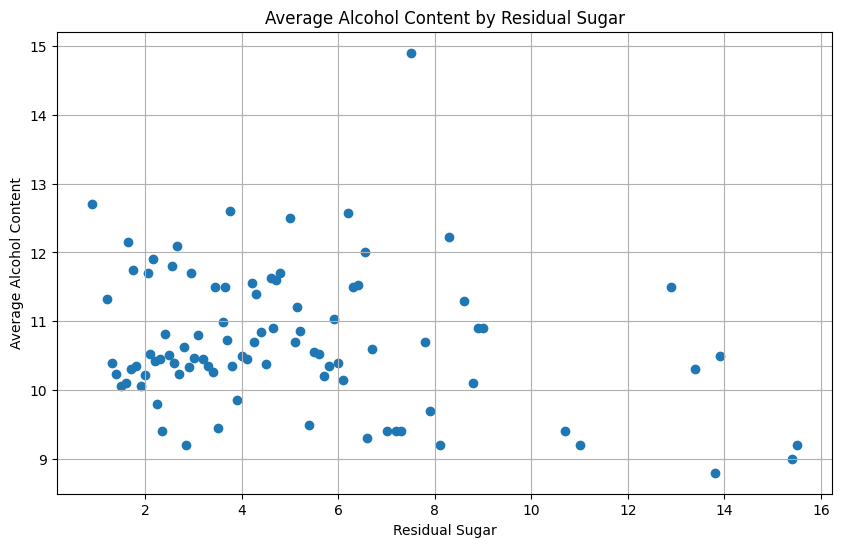

In [97]:
sug_group_pd = sug_group.toPandas()

# Визуализация с использованием графика с точками
plt.figure(figsize=(10, 6))
plt.scatter(sug_group_pd['residual sugar'], sug_group_pd['avg_alcohol'])
plt.title('Average Alcohol Content by Residual Sugar')
plt.xlabel('Residual Sugar')
plt.ylabel('Average Alcohol Content')
plt.grid(True)
plt.show()

In [99]:
from pyspark.sql.functions import when

# Классификация вина по содержанию спирта и сахара
df = df.withColumn('wine_type',
                   when((df['alcohol'] >= 9) & (df['alcohol'] <= 13) & (df['residual sugar'] <= 3), 'Сухие')
                   .when((df['alcohol'] >= 14) & (df['alcohol'] <= 16) & (df['residual sugar'] <= 3), 'Сухие особые')
                   .when((df['alcohol'] >= 9) & (df['alcohol'] <= 13) & (df['residual sugar'] >= 5) & (df['residual sugar'] <= 30), 'Полусухие')
                   .when((df['alcohol'] >= 9) & (df['alcohol'] <= 12) & (df['residual sugar'] >= 30) & (df['residual sugar'] <= 80), 'Полусладкие')
                   .when((df['alcohol'] >= 14) & (df['alcohol'] <= 20) & (df['residual sugar'] <= 15), 'Специальные: Сухие')
                   .when((df['alcohol'] >= 17) & (df['alcohol'] <= 20) & (df['residual sugar'] >= 30) & (df['residual sugar'] <= 120), 'Специальные: Крепкие')
                   .when((df['alcohol'] >= 14) & (df['alcohol'] <= 16) & (df['residual sugar'] >= 50) & (df['residual sugar'] <= 120), 'Специальные: Полудесертные')
                   .when((df['alcohol'] >= 15) & (df['alcohol'] <= 17) & (df['residual sugar'] >= 140) & (df['residual sugar'] <= 200), 'Специальные: Десертные')
                   .when((df['alcohol'] >= 12) & (df['alcohol'] <= 16) & (df['residual sugar'] >= 210) & (df['residual sugar'] <= 300), 'Специальные: Ликёрные')
                   .when((df['alcohol'] >= 16) & (df['alcohol'] <= 18) & ((df['residual sugar'] / 100) >= 6) & ((df['residual sugar'] / 100) <= 16), 'Специальные: Ароматизированные')
                   .otherwise('Неточный тип'))

# Выводим результат
df.select('alcohol', 'residual sugar', 'wine_type').show()



+-------+--------------+------------+
|alcohol|residual sugar|   wine_type|
+-------+--------------+------------+
|    9.4|           1.9|       Сухие|
|    9.8|           2.6|       Сухие|
|    9.8|           2.3|       Сухие|
|    9.8|           1.9|       Сухие|
|    9.4|           1.9|       Сухие|
|    9.4|           1.8|       Сухие|
|    9.4|           1.6|       Сухие|
|   10.0|           1.2|       Сухие|
|    9.5|           2.0|       Сухие|
|   10.5|           6.1|   Полусухие|
|    9.2|           1.8|       Сухие|
|   10.5|           6.1|   Полусухие|
|    9.9|           1.6|       Сухие|
|    9.1|           1.6|       Сухие|
|    9.2|           3.8|Неточный тип|
|    9.2|           3.9|Неточный тип|
|   10.5|           1.8|       Сухие|
|    9.3|           1.7|       Сухие|
|    9.0|           4.4|Неточный тип|
|    9.2|           1.8|       Сухие|
+-------+--------------+------------+
only showing top 20 rows



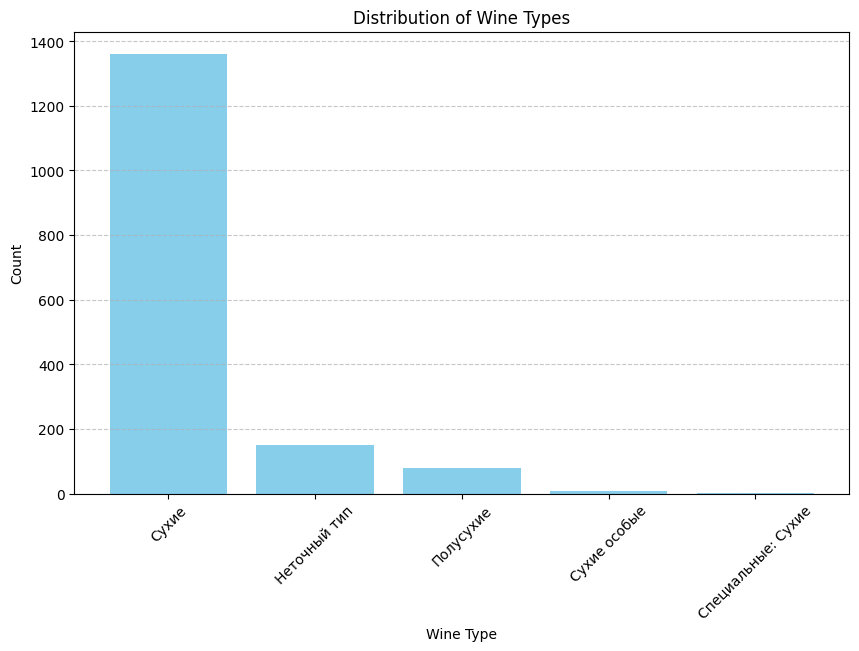

In [100]:
# Подсчет количества вин каждого типа
wine_type_counts = df.groupBy('wine_type').count().orderBy('count', ascending=False).toPandas()

# Визуализация
plt.figure(figsize=(10, 6))
plt.bar(wine_type_counts['wine_type'], wine_type_counts['count'], color='skyblue')
plt.title('Distribution of Wine Types')
plt.xlabel('Wine Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [68]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

# Создание объекта VectorAssembler для объединения признаков в вектор
assembler = VectorAssembler(inputCols=["fixed acidity", "volatile acidity", "citric acid", "residual sugar", 
                                       "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", 
                                       "pH", "sulphates", "alcohol"], outputCol="features")

# Преобразование данных с помощью VectorAssembler
transformed_data = assembler.transform(df)

# Создание объекта MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# Применение MinMaxScaler к данным
scaler_model = scaler.fit(transformed_data)
scaled_data = scaler_model.transform(transformed_data)




# Вывод результата
scaled_data.select("scaled_features").show()


+--------------------+
|     scaled_features|
+--------------------+
|[0.24778761061946...|
|[0.28318584070796...|
|[0.28318584070796...|
|[0.58407079646017...|
|[0.24778761061946...|
|[0.24778761061946...|
|[0.29203539823008...|
|[0.23893805309734...|
|[0.28318584070796...|
|[0.25663716814159...|
|[0.18584070796460...|
|[0.25663716814159...|
|[0.08849557522123...|
|[0.28318584070796...|
|[0.38053097345132...|
|[0.38053097345132...|
|[0.34513274336283...|
|[0.30973451327433...|
|[0.24778761061946...|
|[0.29203539823008...|
+--------------------+
only showing top 20 rows



In [87]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator

# Создаем вектор признаков для классификации
classifier_assembler = VectorAssembler(
    inputCols=["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", 
               "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"],
    outputCol="features")

# Создаем вектор признаков для регрессии
regressor_assembler = VectorAssembler(
    inputCols=["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", 
               "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"],
    outputCol="features")

# Разделение на тест и обучение
train_data, test_data = df.randomSplit([0.8, 0.2], seed = 42)

# Обучение моделей классификации
classifiers = {
    "RandomForestClassifier": RandomForestClassifier(labelCol="quality", featuresCol="features"),
    "LogisticRegression": LogisticRegression(labelCol="quality", featuresCol="features"),
}

for name, classifier in classifiers.items():
    pipeline = Pipeline(stages=[classifier_assembler, classifier])
    model = pipeline.fit(train_data)
    predictions = model.transform(test_data)
    evaluator = MulticlassClassificationEvaluator(labelCol="quality", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print(f"{name} accuracy: {accuracy}")

# Обучение моделей регрессии
regressors = {
    "RandomForestRegressor": RandomForestRegressor(labelCol="quality", featuresCol="features"),
    "LinearRegression": LinearRegression(labelCol="quality", featuresCol="features")
}

for name, regressor in regressors.items():
    pipeline = Pipeline(stages=[regressor_assembler, regressor])
    model = pipeline.fit(train_data)
    predictions = model.transform(test_data)
    evaluator = RegressionEvaluator(labelCol="quality", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    print(f"{name} RMSE: {rmse}")


RandomForestClassifier accuracy: 0.6436363636363637
LogisticRegression accuracy: 0.6545454545454545
RandomForestRegressor RMSE: 0.657037107166696
LinearRegression RMSE: 0.6747363267551549


In [70]:
# Оценка модели с использованием r2
evaluator = RegressionEvaluator(labelCol="quality", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)

print("R-squared (R^2):", r2)

R-squared (R^2): 0.34957255275664356


In [71]:
print("Test Error = %s" % (1.0 - accuracy))

Test Error = 0.34545454545454546


In [88]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator


labelCol = "quality"

# Определение списка признаков
feature_columns = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", 
                   "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", 
                   "pH", "sulphates", "alcohol", "quality"]

# Создание объекта VectorAssembler для объединения признаков в вектор
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Преобразование данных с помощью VectorAssembler
transformed_data = assembler.transform(train_data)

# Создание экземпляра модели RandomForestRegressor
rf = RandomForestRegressor(labelCol=labelCol, featuresCol="features")

# Определение пространства параметров для перебора
param_grid = (ParamGridBuilder()
              .addGrid(rf.numTrees, [50, 100, 150])
              .addGrid(rf.maxDepth, [5, 10, 20])
              .addGrid(rf.minInstancesPerNode, [1, 5, 10])
              .build())

# Создание объекта CrossValidator
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=param_grid,
                          evaluator=RegressionEvaluator(labelCol=labelCol),
                          numFolds=5)

# Объединение модели и процесса кросс-валидации в пайплайн
pipeline = Pipeline(stages=[assembler, crossval])

# Обучение пайплайна на данных
pipeline_model = pipeline.fit(train_data)

# Получение наилучшей модели из пайплайна
best_model = pipeline_model.stages[-1].bestModel


In [89]:
# Получение важности признаков
feature_importances = best_model.featureImportances

# Вывод важности признаков
print("Feature Importances:")
for i, feat in enumerate(feature_columns):
    print(f"{feat}: {feature_importances[i]}")



Feature Importances:
fixed acidity: 0.011528680601652574
volatile acidity: 0.035226879011413095
citric acid: 0.015394329313526741
residual sugar: 0.006245168019620904
chlorides: 0.010940621659684664
free sulfur dioxide: 0.008442360620295035
total sulfur dioxide: 0.015062877211439627
density: 0.020732680624171298
pH: 0.008037557473739526
sulphates: 0.05208458975137039
alcohol: 0.09313675809211443
quality: 0.7231674976209718


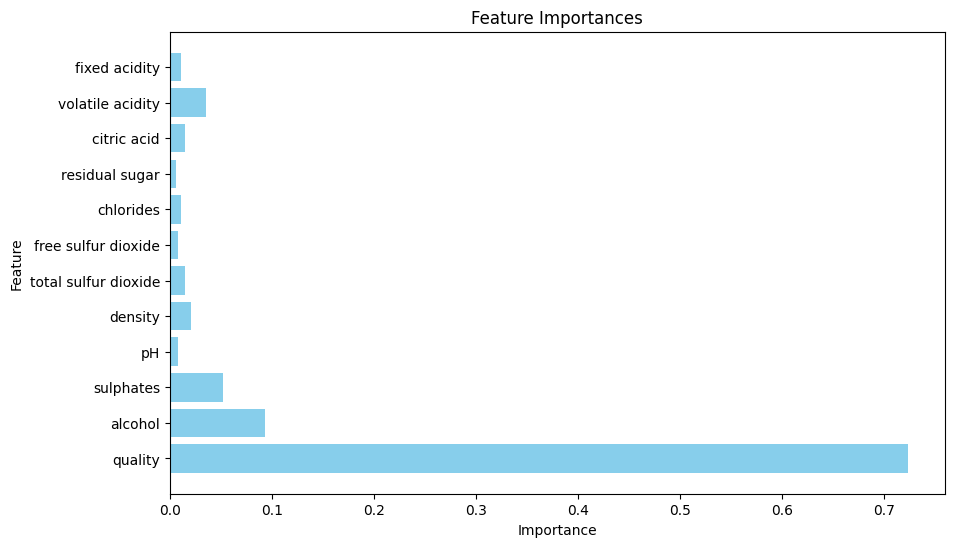

In [107]:
# Список признаков
features = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", 
            "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", 
            "pH", "sulphates", "alcohol", "quality"]
# Построение столбчатой диаграммы
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances, color='skyblue')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  
plt.show()

## Вывод:

Большинство образцов вина имеют качество в диапазоне от 5 до 7. Большинство предствленных вин - сухие.
Наиболее важные признаки при оценке модели: качетсво вина (0.7), алкоголь(0,09), сульфаты(0.05)
В ходе моделирования были использованы как алгоритмы классификации (RandomForestClassifier, LogisticRegression), алгоритмы регрессии (RandomForestRegressor, LinearRegression).
Метрики качества показали, что логистическая регрессия и случайный лес (для классификации) имели сопоставимую точность, а случайный лес (для регрессии) демонстрировал наименьшую среднеквадратичную ошибку (RMSE).

Качество вина может быть эффективно предсказано на основе его химических характеристик, но надо еще доработать:(